# Train CNN model on kss events



In [23]:
import logging

import numpy as np  # linear algebra

from config import Project
from scorers import ConvVar
from src.audio import Audio
from src.kss_df import make_kss_df_cls
from src.model_plot import ModelPlot
from src.shared_params import make_shared_params_cls
from src.training_loader import make_training_loader
from transformers import SlidingWindow
from src.model_wrapper import getKerasWrapper
from keras.utils.generic_utils import get_custom_objects


In [24]:
# Setup

# Import Korean Fonts
k_prop = Project.setup_font()

# Configure matplotlib
plt = Project.setup_plot()

# Display handler with some nice helpers
disp = Project.setup_display()# Uncomment to see the source code
# disp.code('display.py', label='display.py ')


# disp examples
# disp(IPython.display.Audio('./data/korean-single-speaker/kss/1/1_0000.wav'))
# disp_file_source('marker_df.py', label='marker_df')
# disp_audio_file('./data/korean-single-speaker/kss/1/1_0000.wav', label='1_0000.wav')

## Load Training Data

In [25]:
trn_loader = make_training_loader('xy_trn_rms', Project.path.MODEL)
X_train, y_train, _ = trn_loader.load()

disp.obj(X_train, label='X')
disp.obj(y_train, label='y')
disp.obj((X_train.shape, np.mean(X_train)), label='X shape, mean' )
disp.obj((y_train.shape, np.mean(y_train)), label='y shape, mean')

X

array([7.2832445e-05, 8.1853534e-05, 8.1345970e-05, ..., 1.6493888e-03,
       1.9856682e-03, 2.1819461e-03], dtype=float32)

y

array([False, False, False, ..., False, False, False])

X shape, mean

((8895,), 0.23018801)

y shape, mean

((8895,), 0.818999437886453)

## Train Model and Save

We wrap the model in a pipeline as we need to do some transformations (creating windowed features for X).

In [26]:
from keras.models import Sequential
from keras import layers
from custom_loss import conv_loss


print('X,y shapes', X_train.shape, y_train.shape)

X,y shapes (8895,) (8895,)


In [27]:

# TODO: When model_wrapper supports, pass SlidingWindow into model or wrapper constructor

# print('input_shape', input_shape)
#parameters
kernel_size = 3
# optimizer=RMSprop(lr=1e-4)
optimizer='rmsprop'
strides=1

#TODO: Figure out a better way to set NN model input size
sw = SlidingWindow(window=128, offset_percent=0.75)

In [28]:
model_id = 'cnn'
# sw.fit_transform(X_train, y_train)
# y_cnn = sw.y.astype('float64')
# X_cnn = sw.X.reshape(sw.X.shape[0],sw.X.shape[1],1)
# print('X_cnn shape', X_cnn.shape)
# INPUT_SHAPE = (X_cnn.shape[1], X_cnn.shape[2])

# TODO: Convert to a class so we have access to the model and the compiler
def compile_model(model, optimizer='rmsprop', loss='binary_crossentropy'):
    model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=['acc'],
                  run_eagerly=True)
    return model

def create_model(input_shape,
                 optimizer='rmsprop',
                 loss='binary_crossentropy',
                 kernel_size=3,
                 strides=1,
                 nn_activation='relu'):
    model = Sequential()
    # model.add(layers.Embedding(X.shape[0], kernel_size, input_length=input_length))
    model.add(layers.Conv1D(32, kernel_size, activation=nn_activation, strides=strides, input_shape=input_shape))
    model.add(layers.AveragePooling1D(24))
    model.add(layers.Conv1D(64, kernel_size, activation=nn_activation, strides=strides))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()

    # pass run_eagerly=True if there are problems converting Tensors <-> numpy
    return compile_model(model, optimizer, loss)



# TODO: Investigate why custom conv_loss performs so badly
get_custom_objects().update({'conv_loss': conv_loss})
# m = create_model(loss=conv_loss)

_swX= sw.fit_transform(X_train)
_swX = _swX.reshape(_swX.shape + (1,))

INPUT_SHAPE = (_swX.shape[1], _swX.shape[2])
m = create_model(INPUT_SHAPE)
km = getKerasWrapper(model_id, m, Project.path.MODEL, transformer=sw)


SlidingWindow[INFO]: np sliding window shape: (9087, 128)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 126, 32)           128       
_________________________________________________________________
average_pooling1d_2 (Average (None, 5, 32)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3, 64)             6208      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,401
Trainable params: 6,401
Non-trainable params: 0
_________________________________________________________________


In [29]:
history1 = km.fit(X_train, y_train,
                  epochs=5,
                  batch_size=16,
                  validation_split=0.2)

ModelWrapper[INFO]: fitting using model: <keras.engine.sequential.Sequential object at 0x11a413fd0>
SlidingWindow[INFO]: np sliding window shape: (9087, 128)
KerasTransform[INFO]: transformed X, y shapes: (8895, 128), (8895,)


Epoch 1/5
445/445 [==============================] - 11s 24ms/step - loss: 0.3534 - acc: 0.8389 - val_loss: 0.1934 - val_acc: 0.9584

In [30]:

# print(f'Best parameter (CV score={m.search.best_score_:.3f}):')
# print(m.search.best_params_)

# TODO: An interesting thing happened by accident.
#       I recompiled the saved model with a different loss function
#       This continued the training, so basically the model
#       was partly trained with one type of loss (loss1), then a different
#       type of loss was used (loss2). Normally the model performed badly with
#       loss2, but when trained this way, the model performed ok. Unclear how the
#       model(loss1+loss2) performed vs model(loss1). But model(loss1+loss2)>model(loss2)
#       This may be a way of kinda tuning a NN to balance different loss functions. Or
#       it may just be junk. More investigation is needed.

km.save()
saved_unwrapped_model = km.load()
# saved_km = compile_model(saved_km)
saved_unwrapped_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 # loss=conv_loss,
                 metrics=['acc'],
                 run_eagerly=True)

saved_km = getKerasWrapper(model_id, saved_unwrapped_model, Project.path.MODEL, transformer=sw)

VersionedSaver[INFO]: Saving model to: /Users/dev/Projects/korean-ml/data/model/cnn.0.2.model


INFO:tensorflow:Assets written to: /Users/dev/Projects/korean-ml/data/model/cnn.0.2.model/assets


In [31]:
history2 = saved_km.fit(X_train, y_train,
                    epochs=5,
                    batch_size=16,
                    validation_split=0.2)

ModelWrapper[INFO]: fitting using model: <keras.engine.sequential.Sequential object at 0x157755b50>
SlidingWindow[INFO]: np sliding window shape: (9087, 128)
KerasTransform[INFO]: transformed X, y shapes: (8895, 128), (8895,)


Epoch 1/5
445/445 [==============================] - 11s 25ms/step - loss: 0.1695 - acc: 0.9236 - val_loss: 0.1721 - val_acc: 0.9685

<ipython-input-32-dfaff2448374>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs2, acc2, 'bo', label='Training acc2', color='green')
<ipython-input-32-dfaff2448374>:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs2, val_acc2, 'b', label='Validation acc2', color='green')
<ipython-input-32-dfaff2448374>:26: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs2, loss2, 'bo', label='Training loss2', color='green')
<ipython-input-32-dfaff2448374>:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will 

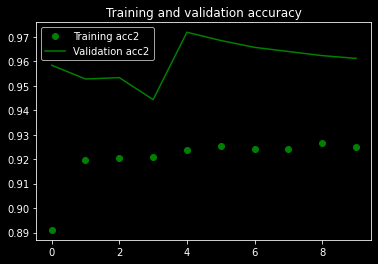

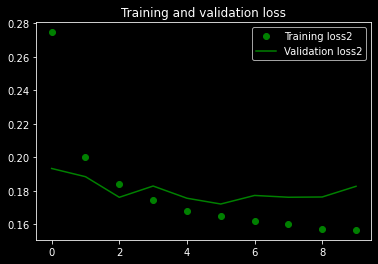

In [32]:

acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

acc2 = acc1 + history2.history['acc']
val_acc2 = val_acc1 + history2.history['val_acc']
loss2 = loss1 + history2.history['loss']
val_loss2 = val_loss1 + history2.history['val_loss']

epochs1 = range(len(acc1))
epochs2 = range(len(acc2))
# epochs = range(len(acc1) + len(acc2))

# plt.plot(epochs1, acc1, 'bo', label='Training acc1')

plt.plot(epochs2, acc2, 'bo', label='Training acc2', color='green')
# plt.plot(epochs1, val_acc1, 'b', label='Validation acc1')
plt.plot(epochs2, val_acc2, 'b', label='Validation acc2', color='green')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

# plt.plot(epochs1, loss1, 'bo', label='Training loss1')
plt.plot(epochs2, loss2, 'bo', label='Training loss2', color='green')
# plt.plot(epochs1, val_loss1, 'b', label='Validation loss1')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss2', color='green')
plt.title('Training and validation loss')
plt.legend()

plt.show()
# sliding_window = SlidingWindow()
# disp.obj(sliding_window, label='SlidingWindow')



## Evaluate Training

Evaluate the training data by seeing if our trained model will predict close to the data it was trained on.

Validation will come later

This is just to make sure our Model trained correctly. It might have overfit, but we don't care yet.

In [33]:
saved_wrap = saved_km
y_train_pred = saved_wrap.predict(X_train)
shared_params = make_shared_params_cls(Project.path.MODEL)().load()

SlidingWindow[INFO]: np sliding window shape: (9087, 128)
KerasTransform[INFO]: transformed X, y shapes: (8895, 128), (8895,)


In [34]:
kss_ids = shared_params['kss']['trn_ids']
print(kss_ids)
audio_params = shared_params['audio']
# iterate over each kss_id, find the audio file, load it and return it's squeezed rms
KssDf = make_kss_df_cls(Project.path.TEXTGRID, Project.path.KSSCSV)
x_rms = np.concatenate([Audio(KssDf(id).audio_path, **audio_params).rms.squeeze() for id in kss_ids])

# TODO: Use sw from model, not here
sw_mean_offset = sw.window-sw.offset
sw_offset = 0

/Users/dev/Projects/korean-ml/venv/lib/python3.9/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(
Audio[INFO]: a.to_rms size: 2431, reduction factor 2430.0
Audio[WARNING]: Modifying input wav from size 175173 to 175232
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 2739, reduction factor 2738.0
Audio[WARNING]: Modifying input wav from size 77573 to 77632
Audio[INFO]: change in number of samples: 59 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1214, reduction factor 1213.0
Audio[WARNING]: Modifying input wav from size 101762 to 101824
Audio[INFO]: change in number of samples: 62 [should be less than hop length: 64]
Audio[INFO]: a.to_rms size: 1592, reduction factor 1591.0
Audio[WARNING]: Modifying input wav from size 58741 to 58752
A

['1_0000', '1_0001', '1_0002', '1_0003', '1_0004']


In [35]:
# sw_pipe = Pipeline([('sw', m.pw.pipe.named_steps['sw'])])
# x_sw = sw_pipe.transform(X_train)

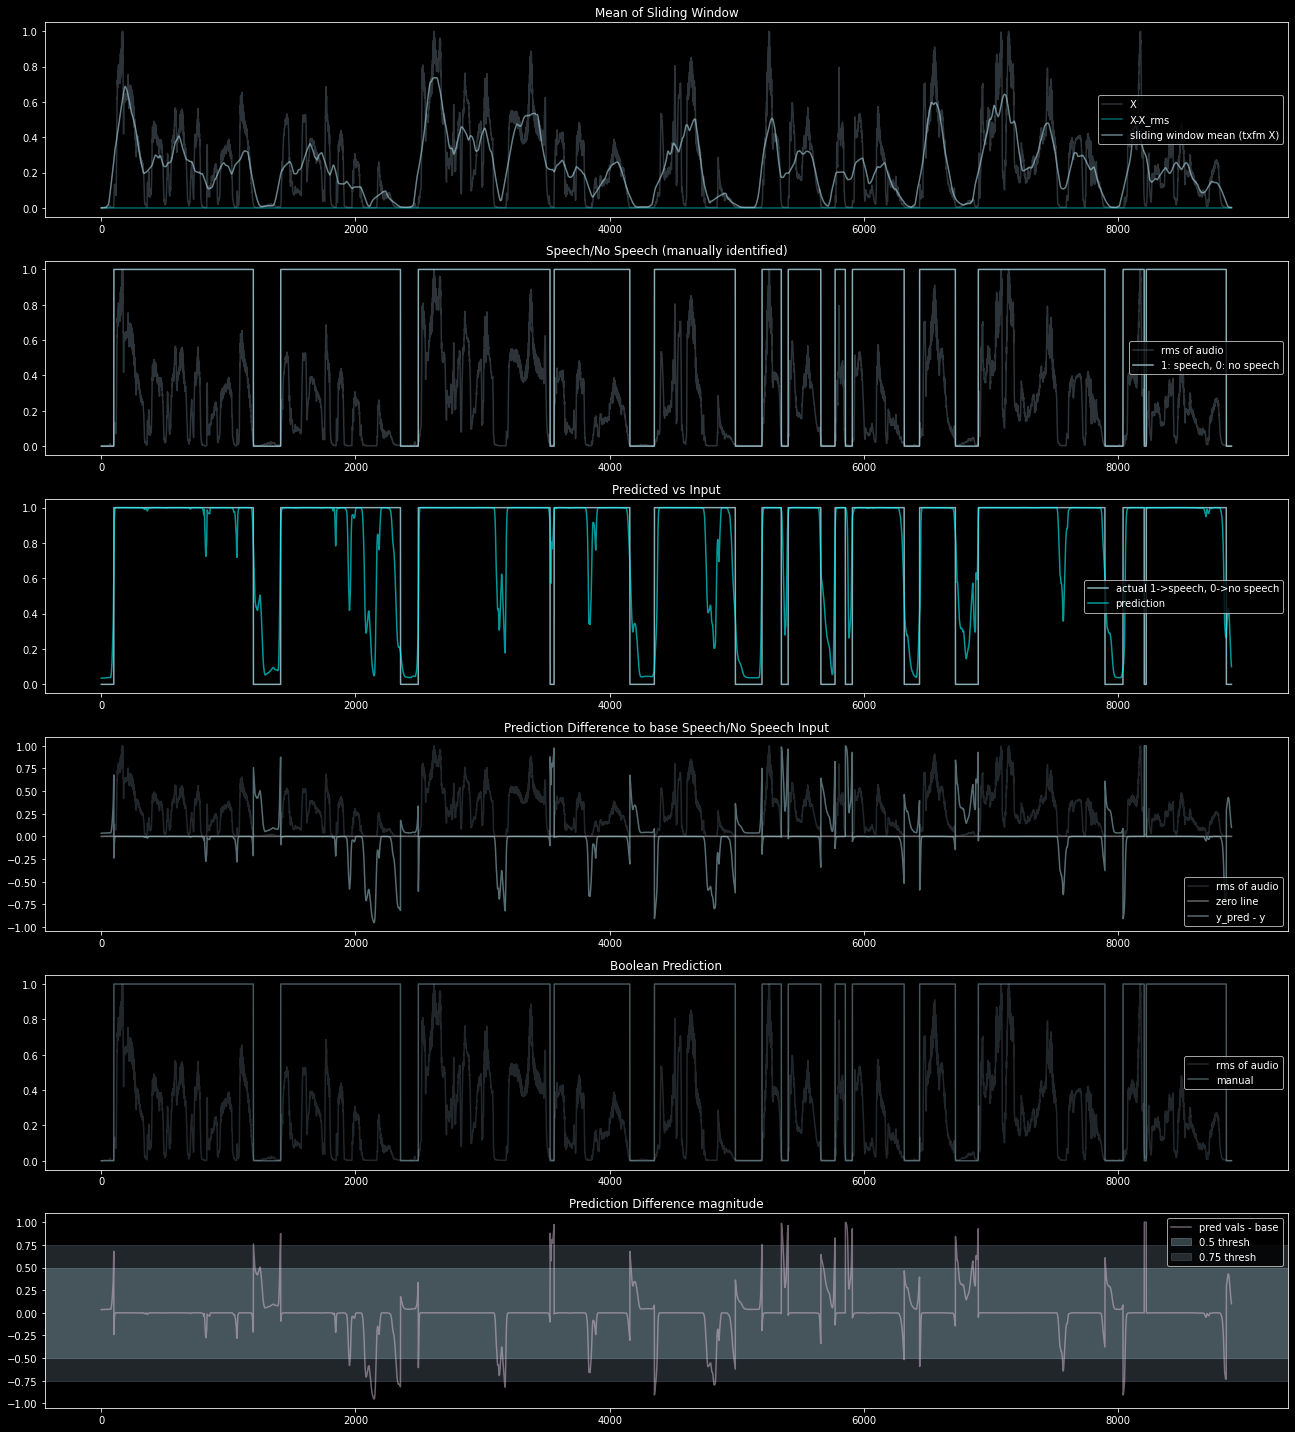

In [36]:
# print(y_train_pred.shape)
#
# print(f'''
# Shapes
# {X_train.shape}: X_train
# {y_train.shape}: y_train
# {y_train_pred.shape}: y_train_pred
# {x_rms.shape}: x_rms
# {x_sw.shape}: x_sw
# {np.mean(x_sw, axis=1).shape}: x_sw mean
#
# Values
# sw_offset: {sw_offset}
# sw_mean_offseet: {sw_mean_offset}
# ''')
# sw_x_mean = np.mean(x_sw, axis=1)
ModelPlot.plot(X_train, y_train, y_train_pred, x_rms, sw)

# _d = np.logical_xor(ModelPlot.align(y_train_pred.squeeze(), sw_offset)[0:8895],
#                     ModelPlot.align(y_train.squeeze(), 0)[0:8895])
# print(_d.shape)

# def plot(X, y, y_pred, x_rms, sliding_window_transformer):
#     x_sw = sliding_window_transformer.transform(X).astype(float)
#     sw_offset = sliding_window_transformer.offset
#     sw_mean_offset = sliding_window_transformer.window - sliding_window_transformer.offset
#
#     # cast values to float so we have a common type to deal with
#     X = X.astype(float)
#     y = y.squeeze().astype(float)
#     y_pred = y_pred.squeeze().astype(float)
#     x_rms = x_rms.astype(float)
#
#     sw_mean = np.mean(x_sw, axis=1).squeeze()
#     # aligned_sw_mean = ModelPlot.align(np.mean(x_sw, axis=1).squeeze(), sw_mean_offset)
#     # aligned_y = ModelPlot.align(y, sw_offset)
#     # aligned_y_pred = ModelPlot.align(y_pred, sw_offset)
#     # y_delta = np.logical_or(aligned_y_pred.astype(int),aligned_y.astype(int))
#     # aligned_y_delta = aligned_y_pred - aligned_y
#     y_diff = y_pred - y
#     # ay = aligned_y_pred[0:8891] - y_pred[0:8891]
#
#     fig, axs = plt.subplots(6, 1, figsize=(18, 20))
#     axs[0].set_title(f'Mean of Sliding Window')
#     axs[0].plot(X, color='lightblue', alpha=0.4, label='X')
#     axs[0].plot(X - x_rms, color='yellow', alpha=0.4, label='X-X_rms')
#     # axs[0].plot(aligned_sw_mean, color='cyan', alpha=0.6, label='sliding window mean (txfm X)')
#     axs[0].plot(sw_mean, color='white', alpha=0.6, label='sliding window mean (txfm X)')
#     axs[0].legend(loc='center right')
#
#     axs[1].set_title(f'Speech/No Speech (manually identified)')
#     axs[1].plot(x_rms, color='slategray', alpha=0.4, label='rms of audio')
#     axs[1].plot(y, color='lightblue', alpha=0.8, label='1: speech, 0: no speech')
#     axs[1].legend(loc='center right')
#
#     axs[2].set_title(f'Predicted vs Input')
#     axs[2].plot(y, color='lightblue', alpha=0.8, label='1: speech, 0: no speech')
#     # axs[2].plot(aligned_y_pred, color='cyan', alpha=0.6, label='prediction')
#     axs[2].plot(y_pred, color='green', alpha=0.6, label='prediction')
#     # axs[2].plot(ay, color='white', alpha=0.6, label='align delta')
#     axs[2].legend(loc='center right')
#
#     axs[3].set_title(f'Difference to base Speech/No Speech Input')
#     axs[3].plot(x_rms, color='slategray', alpha=0.3, label='rms of audio')
#     # axs[3].plot(y.astype(int) - y.astype(int), color='yellow', alpha=0.8, label='base')
#     axs[3].plot(np.zeros(len(y)), color='gray', alpha=0.8, label='zero')
#     # axs[3].plot(aligned_y_delta, color='thistle', alpha=0.5, label='pred delta (aligned)')
#     axs[3].plot(y_diff, color='thistle', alpha=0.5, label='pred delta')
#     axs[3].legend(loc='lower right')
#
#     axs[4].set_title(f'Boolean Prediction')
#     axs[4].plot(x_rms, color='slategray', alpha=0.3, label='rms of audio')
#     axs[4].plot(1 * ModelPlot.pred_threshold(y, 0.5), color='lime', alpha=0.4, label='manual')
#     axs[4].legend(loc='center right')
#
#     axs[5].set_title(f'Prediction Deltas to Base')
#     # axs[5].plot(aligned_y_delta, color='thistle', alpha=0.5,label='pred vals - base')
#     axs[5].plot(y_diff, color='thistle', alpha=0.5,label='pred vals - base')
#     axs[5].axhspan(-0.5, 0.5, color='lightblue', alpha=0.3, label='0.5 thresh'),
#     axs[5].axhspan(-0.75, 0.75, color='slategray', alpha=0.3, label='0.75 thresh')
#     axs[5].legend(loc='upper right')
#
#     plt.tight_layout()
#     plt.show()

# plot(X_train, y_train, y_train_pred, x_rms, sw)

In [37]:
print(y_train.shape, y_train_pred.shape)

print(ConvVar().score(y_train.squeeze(), y_train_pred.squeeze()))


(8895,) (8895, 1)
0.12450621297454048
